In [21]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [3]:
btvote = pd.read_pickle('../data/btvote.pkl')
btvote.head()

,party,vote_19001,vote_19002,vote_19003,vote_19004,vote_19005,vote_19006,vote_19007,vote_19008,vote_19009,...,vote_19235,vote_19236,vote_19237,vote_19238,vote_19239,vote_19240,vote_19241,vote_19242,vote_19243,vote_19244
0,CDU,yes,yes,yes,yes,yes,yes,yes,yes,no,...,yes,yes,yes,yes,yes,yes,no,yes,yes,yes
1,SPD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,yes,yes,yes,yes,yes,yes,no,absence,absence,absence
2,Linke,no,no,no,no,no,no,no,no,yes,...,no,no,no,no,no,no,no,abstain,no,no
3,CDU,yes,yes,yes,yes,yes,yes,yes,yes,no,...,yes,yes,yes,yes,yes,yes,no,yes,yes,absence
4,Linke,absence,absence,absence,absence,absence,absence,absence,absence,absence,...,no,no,no,no,no,no,no,abstain,no,absence


# Split data and encode target variable

In [6]:
# Split dataframe in 'data' and 'target'
btvote_data = btvote.drop('party', axis=1)
btvote_target = btvote['party']

# Encode the target variable
label_encoder = preprocessing.LabelEncoder()
btvote_target = label_encoder.fit_transform(btvote_target)

# Pipeline and GridSearch setup

In the pipeline we include the SimpleImputer with the strategy 'most_frequent' as a result of the experiments in the previous notebook.\
For Balancing, we try out RandomOverSampler, RandomUnderSampler and no Sampling.\
As an estimator, we consider nearest-neighbor, Decision Tree and Naive Bayes. In a later notebook more models will be analysed in detail. For the moment, this selection of estimators should just ensure well-founded results for the different balancing approaches.

In [7]:
from imblearn.pipeline import Pipeline
# normalisation
from sklearn.preprocessing import OneHotEncoder
# imputer
from sklearn.impute import SimpleImputer
# balancing
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
# classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# Pipeline
pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False)), ('balancing', None), ('estimator', None)])

# set parameter grid
parameters = {
    'balancing': [RandomOverSampler(), RandomUnderSampler(), None],
    'estimator': [KNeighborsClassifier(n_neighbors=7), DecisionTreeClassifier(max_depth=5), GaussianNB()],
}

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

# specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# define the scoring function
# Note: We use 'macro' as average as we want to evaluate the performance of each class equally, regardless of the class size
f1 = make_scorer(f1_score, average='macro')

# Balancing evaluation

In [12]:
# create the grid search instance
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=stratified_10_fold_cv, error_score='raise')

# run the grid search
grid_search_estimator.fit(btvote_data, btvote_target)

# results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)

# pivot the results for better visualization
results['param_balancing'] = results['param_balancing'].astype(str)
results['param_estimator'] = results['param_estimator'].astype(str)
pivoted_results = results.pivot(index='param_balancing', columns='param_estimator', values='mean_test_score')
pivoted_results['Average'] = pivoted_results[['DecisionTreeClassifier(max_depth=5)','GaussianNB()','KNeighborsClassifier(n_neighbors=7)']].mean(axis=1)
display(pivoted_results)

param_estimator,DecisionTreeClassifier(max_depth=5),GaussianNB(),KNeighborsClassifier(n_neighbors=7),Average
param_balancing,,,,
None,0.666071,0.705059,0.673475,0.681535
RandomOverSampler(),0.600572,0.704746,0.698460,0.667926
RandomUnderSampler(),0.620851,0.630640,0.669218,0.640236


We already see that Balacing the data doesn't necessarily improve the macro F1-score. We now go further into detail by showing the confusion matrix for Naive Bayes.

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Create train and test data
btvote_data_train, btvote_data_test, btvote_target_train, btvote_target_test = train_test_split(btvote_data, btvote_target, random_state=42)

### Naive Bayes

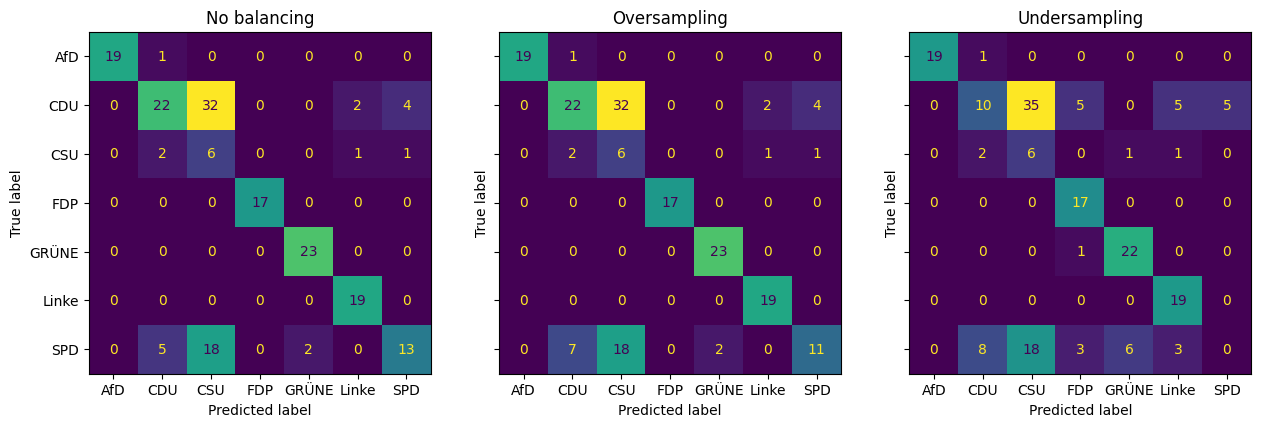

In [39]:
# Plot one confusion matrix for each balancing approach
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))

# No balancing
pipeline.set_params(balancing=None, estimator=GaussianNB())
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[0].set_title("No balancing")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[0], colorbar=False)

# Oversampling
pipeline = pipeline.set_params(balancing=RandomOverSampler())
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[1].set_title("Oversampling")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[1], colorbar=False)

# Undersampling
pipeline = pipeline.set_params(balancing=RandomUnderSampler())
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[2].set_title("Undersampling")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[2], colorbar=False)

plt.show()

### Decision Tree Classifier

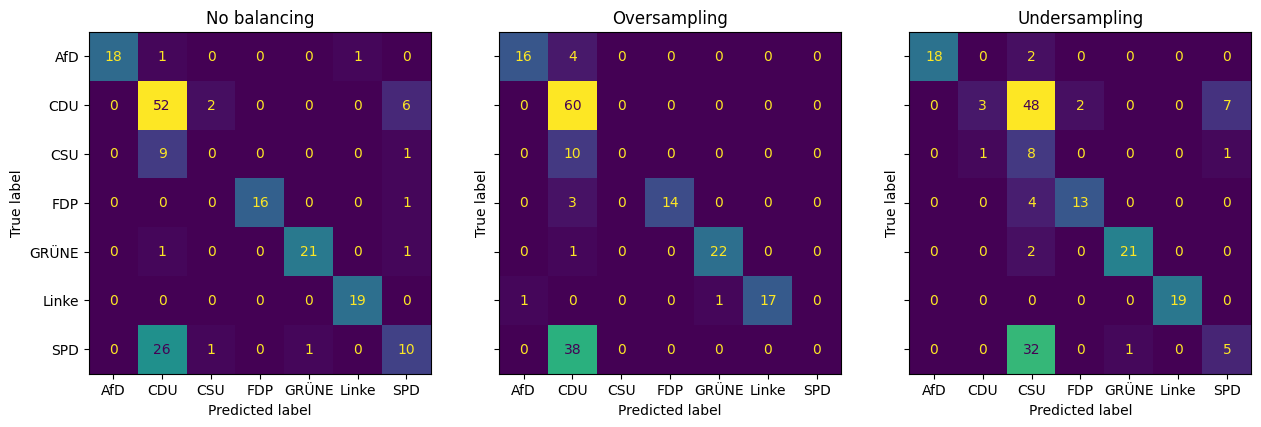

In [42]:
# Plot one confusion matrix for each balancing approach
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))

# No balancing
pipeline.set_params(balancing=None, estimator=DecisionTreeClassifier(max_depth=5))
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[0].set_title("No balancing")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[0], colorbar=False)

# Oversampling
pipeline = pipeline.set_params(balancing=RandomOverSampler())
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[1].set_title("Oversampling")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[1], colorbar=False)

# Undersampling
pipeline = pipeline.set_params(balancing=RandomUnderSampler())
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[2].set_title("Undersampling")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[2], colorbar=False)

plt.show()

### Nearest Neighbor Classifier

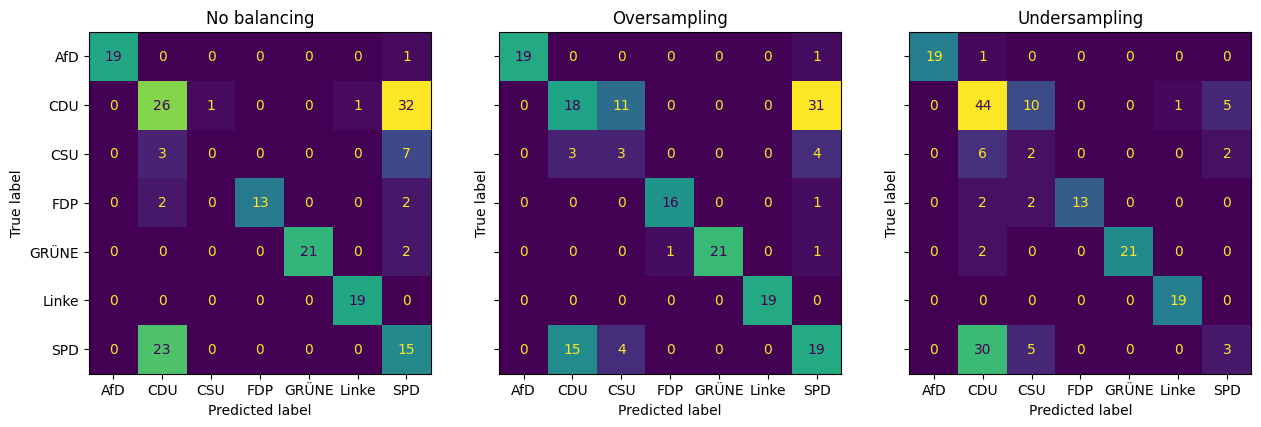

In [43]:
# Plot one confusion matrix for each balancing approach
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))

# No balancing
pipeline.set_params(balancing=None, estimator=KNeighborsClassifier(n_neighbors=7))
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[0].set_title("No balancing")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[0], colorbar=False)

# Oversampling
pipeline = pipeline.set_params(balancing=RandomOverSampler())
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[1].set_title("Oversampling")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[1], colorbar=False)

# Undersampling
pipeline = pipeline.set_params(balancing=RandomUnderSampler())
pipeline.fit(btvote_data_train, btvote_target_train)
prediction = pipeline.predict(btvote_data_test)
axs[2].set_title("Undersampling")
ConfusionMatrixDisplay(confusion_matrix(btvote_target_test, prediction), display_labels=label_encoder.classes_).plot(ax=axs[2], colorbar=False)

plt.show()

**Notable observations:**

- GaussianNB: When performing undersampling, the predictions for CDU and SPD are more skewed. The Undersampler struggles with CDU and CSU
- DecisionTree: Generally, CDU and SPD are more overlapped. Undersampling is again bad due to false predictions for CDU and CSU.
- NearestNeighborClassifier: Performance is similar for all balancing approaches. The error lies either more in (CDU,SPD) oder (SPD,CDU)

# Conclusion

Interestingly, the false predictions in the confusion matrix mostly lie between CDU and SPD. These are the parties that are the most represented in the Bundestag. So, no oversampling of fewer represented parties is necessary. In two of three cases Undersampling results in nearly all CDU MPs beeing predicted to the CSU. So, the amount of data for the CDU shouldn't be reduced. In conclusion that means, that no balancing is necessary. In future experiments we will therefore remove balancing from the pipeline.